# Using large language models for exploratory data analysis

The following Google Colab notebook implements an simple exploratory data analysis with Vanna.a, Azure's OpenAI GPT-4 on a SQLite3's northwind database.

### Install Libraries

In [9]:
!pip3 install --quiet 'vanna[chromadb,openai]'

### Download the Northwind database for SQLite3

In [10]:
!wget https://tdmdal.github.io/mma-sql-2021/data/northwind.sqlite3

--2024-01-21 15:05:08--  https://tdmdal.github.io/mma-sql-2021/data/northwind.sqlite3
Resolving tdmdal.github.io (tdmdal.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to tdmdal.github.io (tdmdal.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 804864 (786K) [application/octet-stream]
Saving to: ‘northwind.sqlite3.1’

northwind.sqlite3.1 100%[===================>] 786.00K  5.01MB/s    in 0.2s    

2024-01-21 15:05:09 (5.01 MB/s) - ‘northwind.sqlite3.1’ saved [804864/804864]



### Load the SQL magic extension

[this extension](https://github.com/catherinedevlin/ipython-sql) allows us to connect to DBs and issue SQL command

In [11]:
%load_ext sql

In [109]:
%%sql
sqlite:///northwind.sqlite3

In [110]:
%%sql
CREATE VIEW INFORMATION_SCHEMA_TABLES AS
    SELECT 'main'     AS TABLE_CATALOG,
           'sqlite'   AS TABLE_SCHEMA,
           tbl_name   AS TABLE_NAME,
           CASE WHEN type = 'table' THEN 'BASE TABLE'
                WHEN type = 'view'  THEN 'VIEW'
           END        AS TABLE_TYPE,
           sql        AS TABLE_SOURCE
    FROM   sqlite_master
    WHERE  type IN ('table', 'view')
           AND tbl_name NOT LIKE 'INFORMATION_SCHEMA_%'
    ORDER BY TABLE_TYPE, TABLE_NAME;

 * sqlite:///northwind.sqlite3
Done.


[]

In [95]:
import vanna
from vanna.openai.openai_chat import OpenAI_Chat
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore
from vanna.remote import VannaDefault
import getpass

In [94]:
print("Please enter your Vanna.ai key")
API_KEY = getpass.getpass()

Please enter your Vanna.ai key
··········


In [ ]:
print("Please enter your Vanna.ai model")
MODEL = getpass.getpass()

In [96]:
vn = VannaDefault(model=MODEL, api_key=API_KEY)

In [97]:
odbc_str = "northwind.sqlite3"
vn.connect_to_sqlite(odbc_str)

SELECT COUNT(*) AS num_orders
FROM orders;


,num_orders
0,830


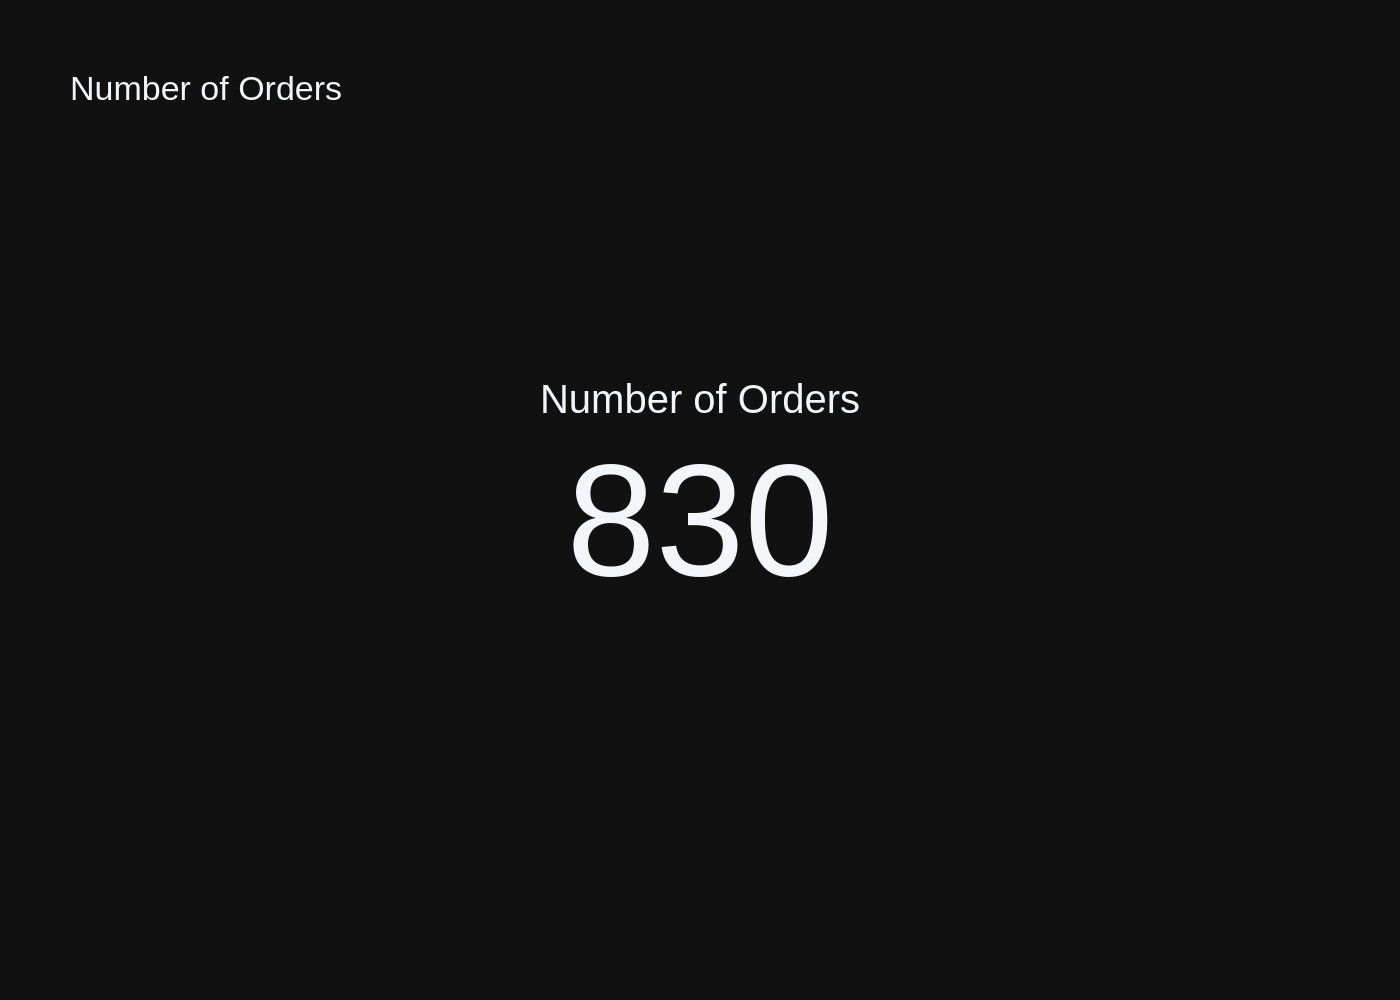

In [98]:
vn.ask("how many orders?")

In [131]:
df_information_schema = vn.run_sql("SELECT * FROM INFORMATION_SCHEMA_TABLES")

In [114]:
df_information_schema.head()

,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE,TABLE_SOURCE
0,main,sqlite,Categories,BASE TABLE,CREATE TABLE [Categories] (\n [CategoryID] IN...
1,main,sqlite,Customers,BASE TABLE,CREATE TABLE [Customers] (\n [CustomerID] nch...
2,main,sqlite,Employees,BASE TABLE,CREATE TABLE [Employees] (\n [EmployeeID] INT...
3,main,sqlite,OrderDetails,BASE TABLE,CREATE TABLE [OrderDetails] (\n [OrderID] int...
4,main,sqlite,Orders,BASE TABLE,CREATE TABLE [Orders] (\n [OrderID] INTEGER P...


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('TABLE_NAME').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('TABLE_SOURCE').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['TABLE_SOURCE'].value_counts()
    for x_label, grp in _df_2.groupby('TABLE_NAME')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('TABLE_NAME')
_ = plt.ylabel('TABLE_SOURCE')

In [120]:

for index, row in df_information_schema.iterrows():
    vn.train(ddl=row["TABLE_SOURCE"])

Adding ddl: CREATE TABLE [Categories] (
  [CategoryID] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL
, [CategoryName] nvarchar(15) NOT NULL COLLATE NOCASE
, [Description] ntext NULL
, [Picture] image NULL
)
Adding ddl: CREATE TABLE [Customers] (
  [CustomerID] nchar(5) NOT NULL
, [CompanyName] nvarchar(40) NOT NULL COLLATE NOCASE
, [ContactName] nvarchar(30) NULL COLLATE NOCASE
, [ContactTitle] nvarchar(30) NULL COLLATE NOCASE
, [Address] nvarchar(60) NULL COLLATE NOCASE
, [City] nvarchar(15) NULL COLLATE NOCASE
, [Region] nvarchar(15) NULL COLLATE NOCASE
, [PostalCode] nvarchar(10) NULL COLLATE NOCASE
, [Country] nvarchar(15) NULL COLLATE NOCASE
, [Phone] nvarchar(24) NULL COLLATE NOCASE
, [Fax] nvarchar(24) NULL COLLATE NOCASE
, CONSTRAINT [PK_Customers] PRIMARY KEY ([CustomerID])
)
Adding ddl: CREATE TABLE [Employees] (
  [EmployeeID] INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL
, [LastName] nvarchar(20) NOT NULL COLLATE NOCASE
, [FirstName] nvarchar(10) NOT NULL COLLATE NOCASE
, [Title]

SELECT CategoryName, Description
FROM categories
ORDER BY CategoryName;


,CategoryName,Description
0,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,Confections,"Desserts, candies, and sweet breads"
3,Dairy Products,Cheeses
4,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,Meat/Poultry,Prepared meats
6,Produce,Dried fruit and bean curd
7,Seafood,Seaweed and fish


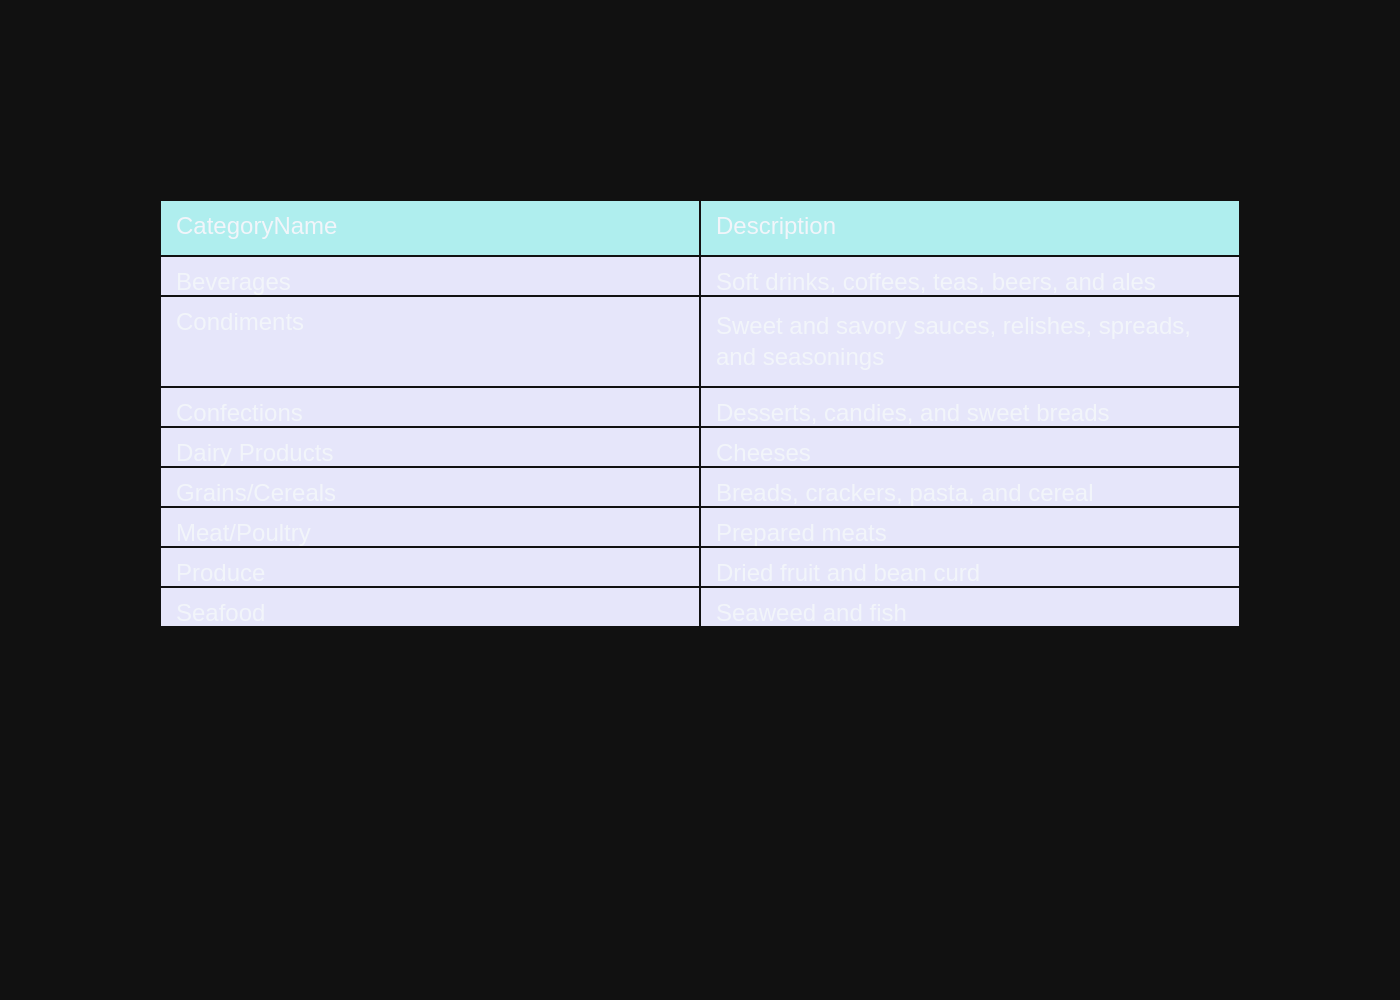

In [125]:
vn.ask(question="Create a report that shows the CategoryName and Description from the categories table sorted by CategoryName.")

SELECT OrderID, OrderDate, ShippedDate, CustomerID, Freight
FROM orders
ORDER BY Freight DESC
LIMIT 10;


,OrderID,OrderDate,ShippedDate,CustomerID,Freight
0,10806,2015-12-31 11:00:00.000,2016-01-05 00:00:00.000,VICTE,2000.00
1,10540,2015-05-19 05:00:00.000,2015-06-13 00:00:00.000,QUICK,1007.64
2,10372,2014-12-04 10:00:00.000,2014-12-09 00:00:00.000,QUEEN,890.78
3,11030,2016-04-17 15:00:00.000,2016-04-27 00:00:00.000,SAVEA,830.75
4,10691,2015-10-03 14:00:00.000,2015-10-22 00:00:00.000,QUICK,810.05
5,10514,2015-04-22 08:00:00.000,2015-05-16 00:00:00.000,ERNSH,789.95
6,11017,2016-04-13 12:00:00.000,2016-04-20 00:00:00.000,ERNSH,754.26
7,10816,2016-01-06 22:00:00.000,2016-02-04 00:00:00.000,GREAL,719.78
8,10479,2015-03-19 01:00:00.000,2015-03-21 00:00:00.000,RATTC,708.95
9,10983,2016-03-27 15:00:00.000,2016-04-06 00:00:00.000,SAVEA,657.54


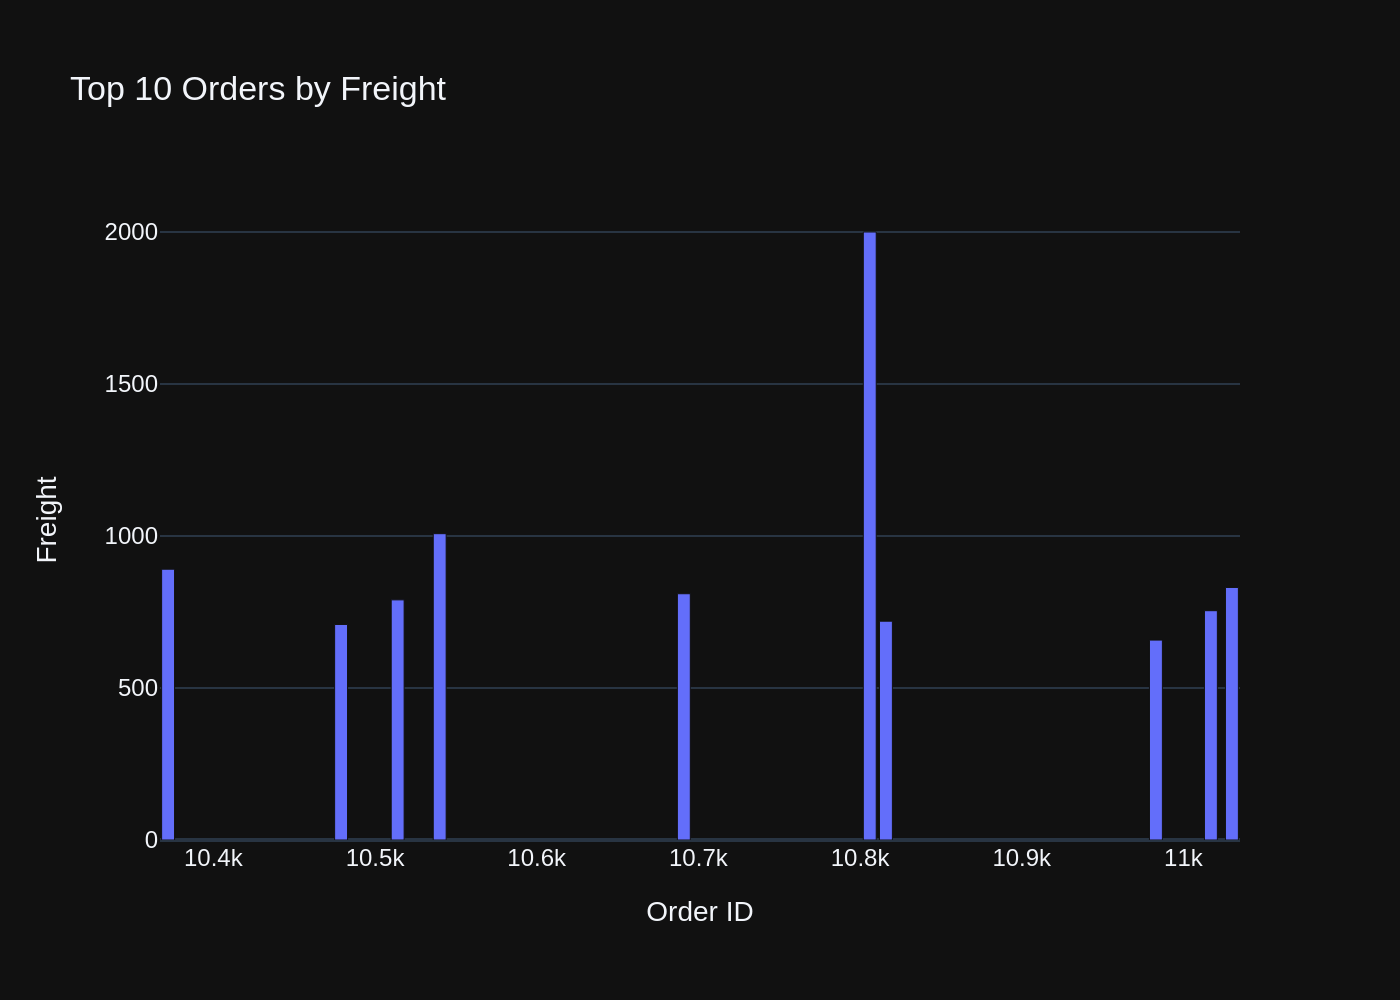

In [127]:
vn.ask("Create a report that shows the top 10 OrderID, OrderDate, ShippedDate, CustomerID, Freight from the orders table sorted by Freight in descending order.")

SELECT LastName, FirstName, City
FROM employees
WHERE City <> 'Seattle';


,LastName,FirstName,City
0,Fuller,Andrew,Tacoma
1,Leverling,Janet,Kirkland
2,Peacock,Margaret,Redmond
3,Buchanan,Steven,London
4,Suyama,Michael,London
5,King,Robert,London
6,Dodsworth,Anne,London


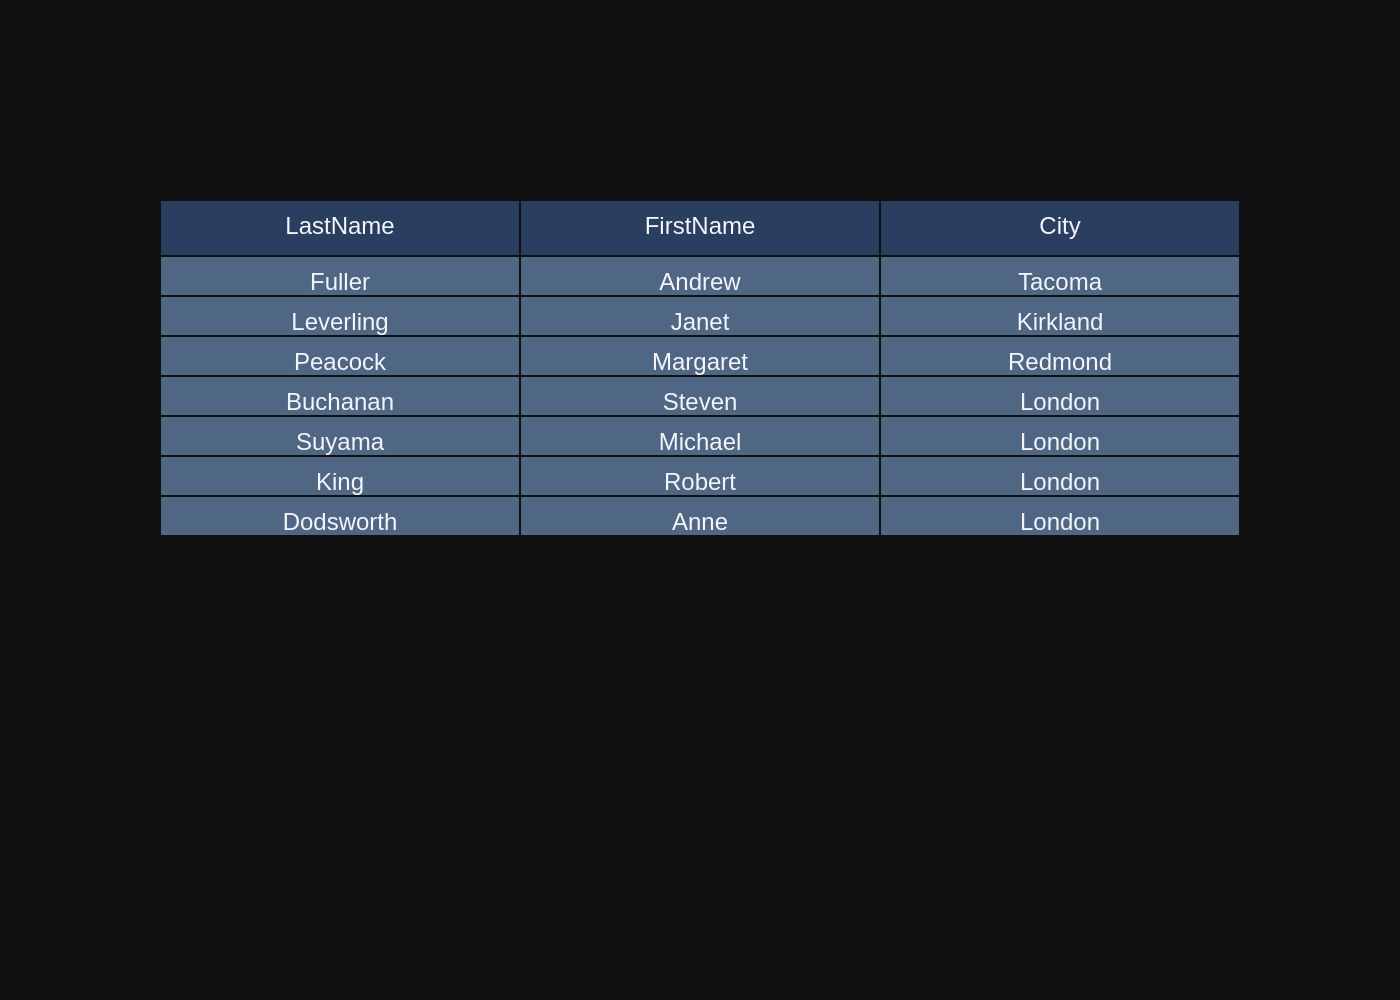

In [136]:
vn.ask("Create a report that shows the LastName, FirstName, City of employees in cities other than Seattle")

SELECT c.CompanyName, COUNT(o.OrderID) AS NumberOfOrders
FROM Customers c
INNER JOIN Orders o ON c.CustomerID = o.CustomerID
WHERE o.OrderDate > '1994-12-31'
GROUP BY c.CompanyName
HAVING COUNT(o.OrderID) > 10;


,CompanyName,NumberOfOrders
0,Around the Horn,13
1,Berglunds snabbköp,18
2,Blondesddsl père et fils,11
3,Bon app',17
4,Bottom-Dollar Markets,14
5,Ernst Handel,30
6,Folk och fä HB,19
7,Frankenversand,15
8,Great Lakes Food Market,11
9,Hanari Carnes,14


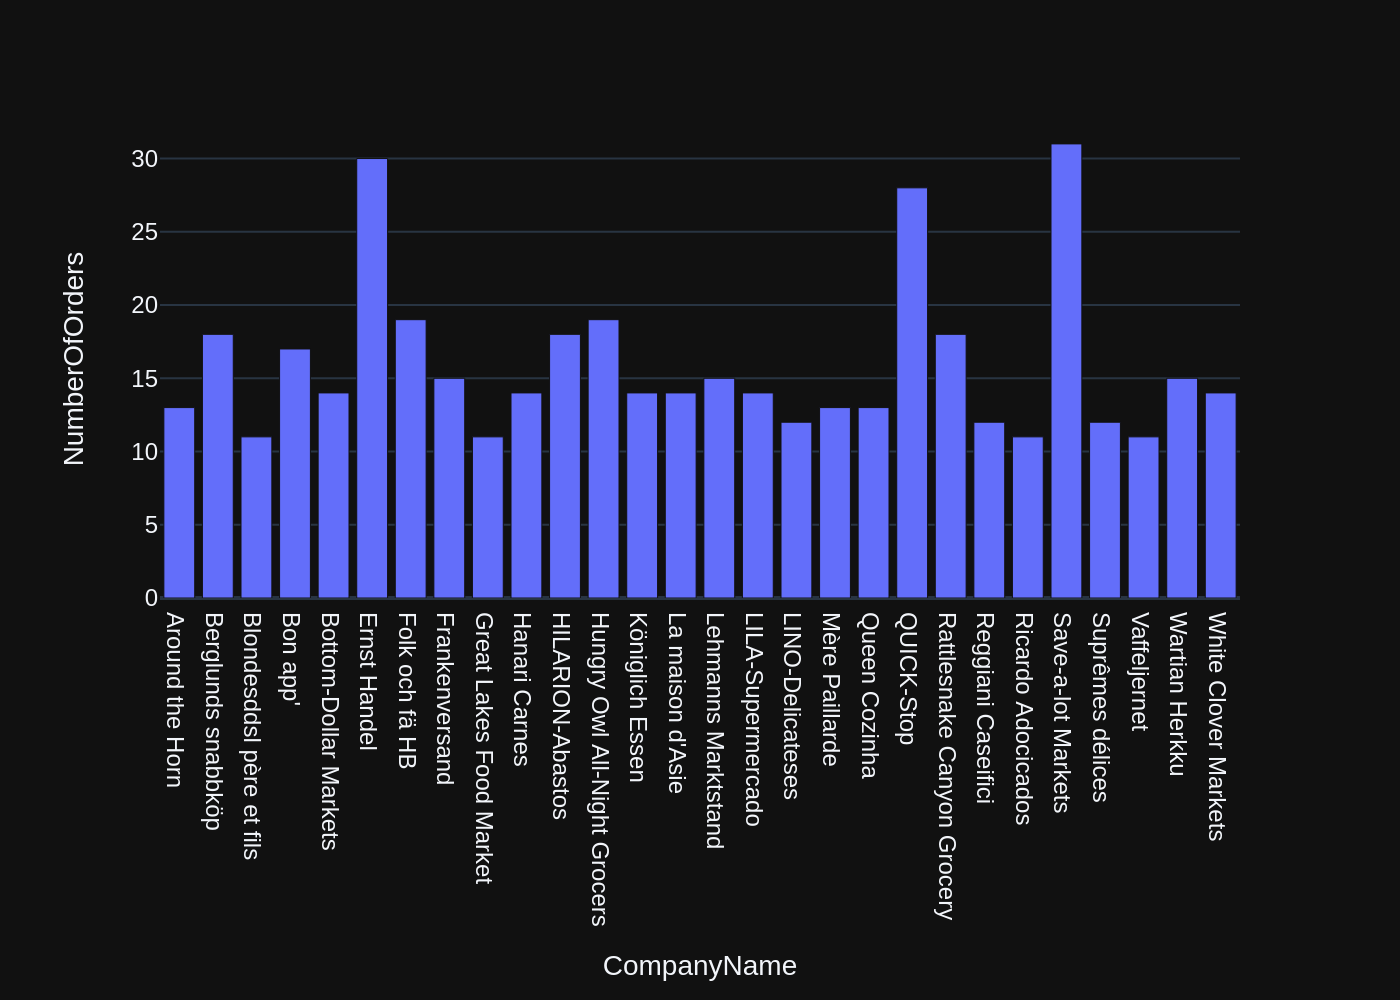

In [141]:
vn.ask("Create a report that the CompanyName and total number of orders by customer renamed as number of orders since December 31, 1994. Show number of Orders greater than 10")

SELECT p.SupplierID, p.ProductName, s.CompanyName 
FROM Products p
JOIN Suppliers s ON p.SupplierID = s.SupplierID
WHERE s.CompanyName IN ('Exotic Liquids', 'Specialty Biscuits, Ltd.', 'Escargots Nouveaux')
ORDER BY p.SupplierID;


,SupplierID,ProductName,CompanyName
0,1,Chai,Exotic Liquids
1,1,Chang,Exotic Liquids
2,1,Aniseed Syrup,Exotic Liquids
3,8,Teatime Chocolate Biscuits,"Specialty Biscuits, Ltd."
4,8,Sir Rodney's Marmalade,"Specialty Biscuits, Ltd."
5,8,Sir Rodney's Scones,"Specialty Biscuits, Ltd."
6,8,Scottish Longbreads,"Specialty Biscuits, Ltd."
7,27,Escargots de Bourgogne,Escargots Nouveaux


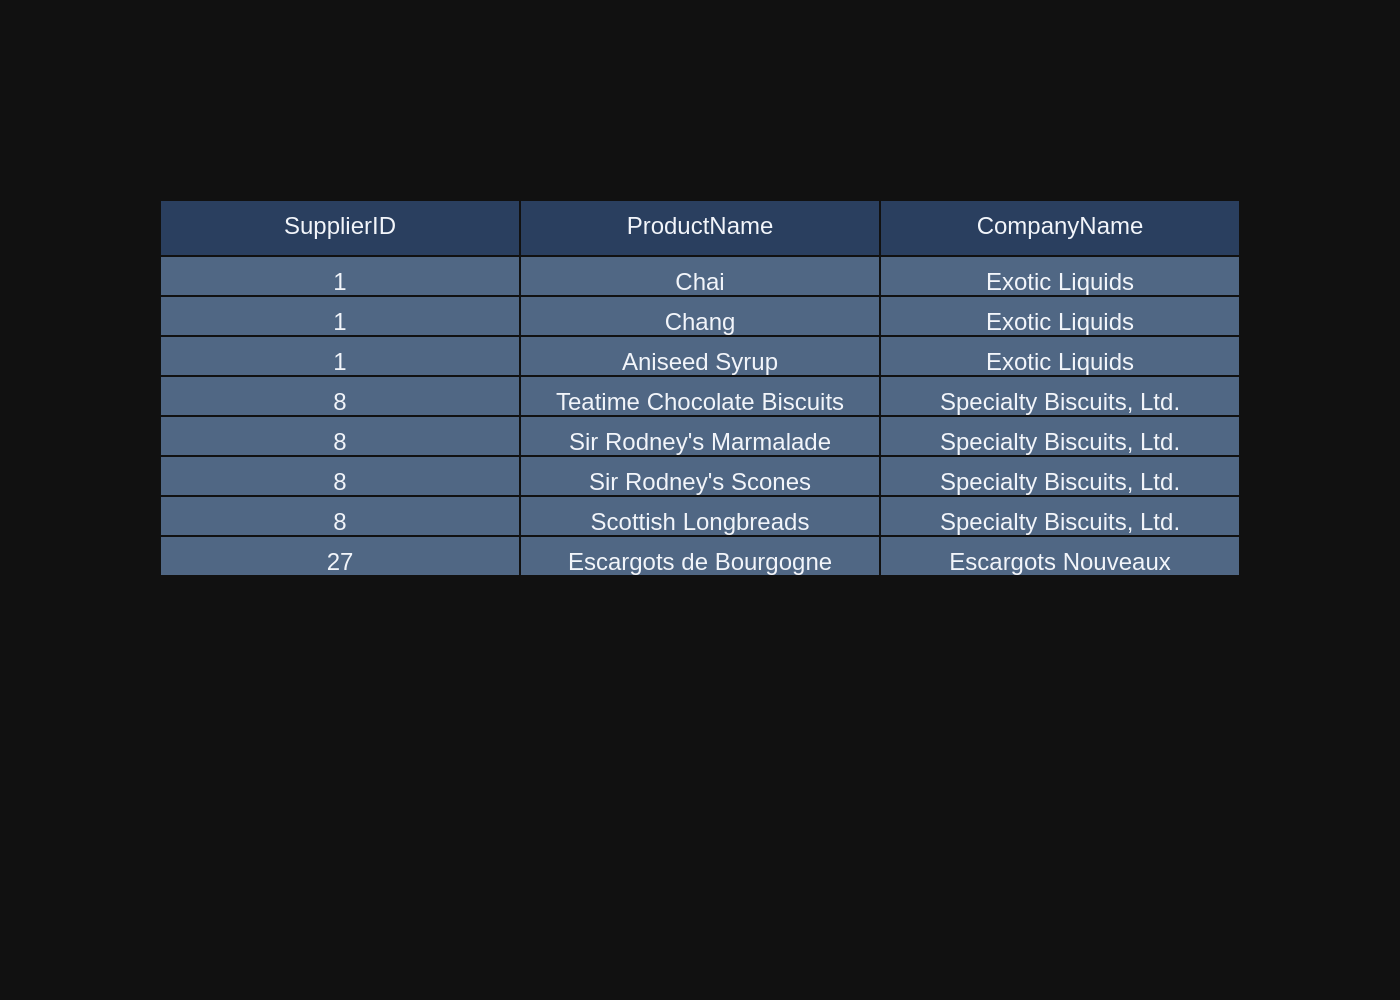

In [137]:
vn.ask("reate a report that shows the SupplierID, ProductName, CompanyName from all product Supplied by Exotic Liquids, Specialty Biscuits, Ltd., Escargots Nouveaux sorted by the supplier ID")

SELECT OrderID, COUNT(OrderID) AS NumberofOrders
FROM orderdetails
GROUP BY OrderID
ORDER BY NumberofOrders DESC;


,OrderID,NumberofOrders
0,11077,25
1,10657,6
2,10847,6
3,10979,6
4,10273,5
...,...,...
825,11057,1
826,11061,1
827,11067,1
828,11069,1


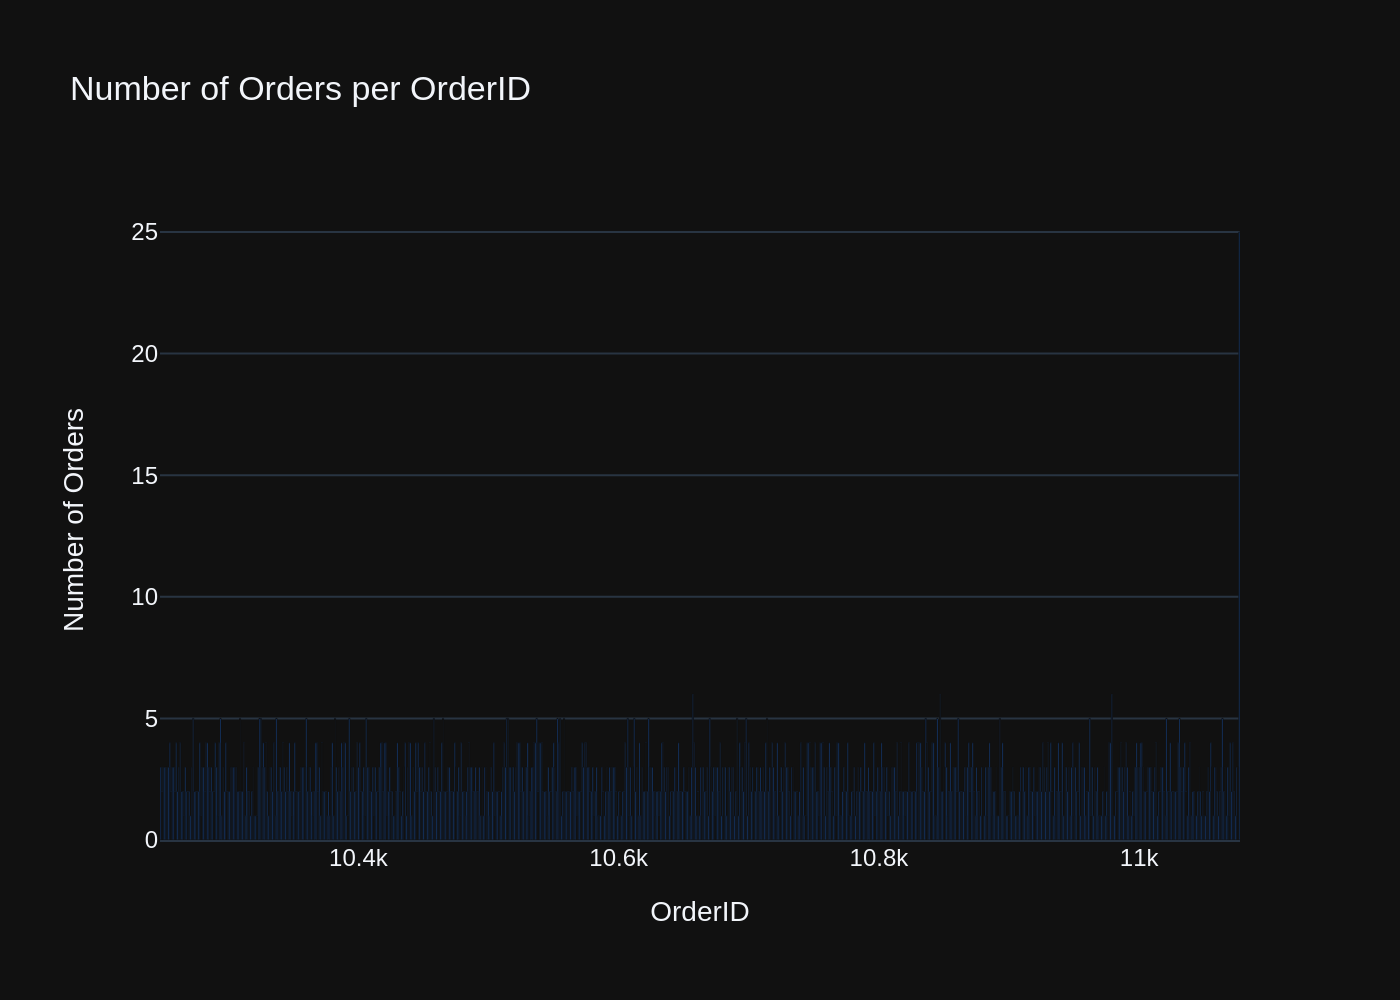

In [129]:
vn.ask("Create a report showing OrderID, total number of Order ID as NumberofOrders from the orderdetails table grouped by OrderID and sorted by NumberofOrders in descending order")